In [ ]:
%load_ext autoreload
%autoreload 2

# Exploring the model output: orbits and weights

In [2]:
import sys
sys.path.insert(0,'../../')
import dynamite as dyn

fname = 'NGC6278_config.yaml'
c = dyn.config_reader.Configuration(fname, silent=True)

parset = c.parspace.get_parset()

model = dyn.model.LegacySchwarzschildModel(
    system=c.system,
    settings=c.settings,
    parspace=c.parspace,
    executor=c.executor,
    parset=parset)

NGC6278_output/all_models.ecsv
making empty table attribute
I love Slurm!
I love Slurm even more!!


## Looking at the orbit library

We created an orbit library. It would be nice to look at some of these orbits, or at least their line-of-sight velocity distribtions (LOSVDs). To read them,

In [3]:
model.get_orblib()
model.orblib.read_losvd_histograms()

which creates the object``model.orblib.losvd_histograms`` with the following properties

In [4]:
print(f'Orbits are stores as a {type(model.orblib.losvd_histograms)}')
print(f'velocity array has shape {model.orblib.losvd_histograms.x.shape}')
print(f'LOSVD has shape {model.orblib.losvd_histograms.y.shape}')

Orbits are stores as a <class 'kinematics.Histogram'>
velocity array has shape (205,)
LOSVD has shape (180, 205, 152)


Where do these numbers come from? They are set by values in the configuration file of course! The length of the velocity array is given by

In [5]:
c.settings.orblib_settings['hist_bins']

'205'

This is also the size of the second dimension of the LOSVD. The size of the first dimension - 180 - is the number of orbits in our library. This is also specified by values in the configuration file, i.e.

In [6]:
tmp = c.settings.orblib_settings
print(3 * tmp['nE'] * tmp['nI2'] * tmp['nI3'])

180


The values (nE, nI2, nI3) are our specified grid size in orbtial integrals of motion. The factor of 3 comes from the fact that we combine three libraries with this grid size.

The final dimension size of the LOSVD - 152 - is the number of spatial apertures. It should be equal (always? I think?) to the number of apertures for which we have provided kinematic data, i.e. the number of rows of the kinematic data file, i.e.

In [7]:
len(c.system.cmp_list[2].kinematic_data[0].data)

152

So - the LOSVD histogram has shape
$$
(n_\mathrm{orbits}, n_\mathrm{velocityBins}, n_\mathrm{apertures})
$$
i.e. an LOSVD per orbit, per spatial aperture. Let's write simple plotting routine to look at some examples,

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_losvds(losvd_histogram, orb_idx, aperture_idx_list):
    v = losvd_histogram.x
    losvd = losvd_histogram.y[orb_idx, :, :]
    plt.plot(v, np.sum(losvd, 1), label='total')
    for aperture_idx in aperture_idx_list:
        plt.plot(v,
                 losvd[:, aperture_idx],
                 '--',
                 label=f'aperture {aperture_idx}')
    plt.gca().set_title(f'LOSVD of orbit {orb_idx}')
    plt.gca().set_xlabel('v [km/s]')
    plt.gca().set_yscale('log')
    plt.gca().legend()
    plt.tight_layout()
    return

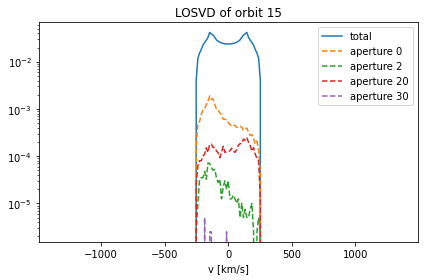

In [9]:
orb_idx = 15
aperture_idx_list = [0, 2, 20, 30]
plot_losvds(model.orblib.losvd_histograms, orb_idx, aperture_idx_list)

In some apertures, this orbit hardly contributes at all. One of these orbits looks interesting - the one in aperture 20. Let's plot this one on its own,

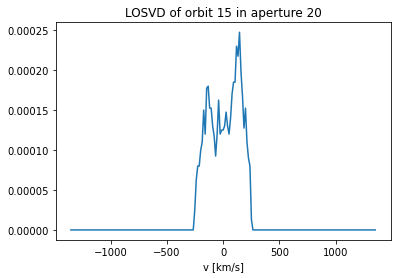

In [10]:
orb_idx, aperture_idx = 15, 20
v_arr = model.orblib.losvd_histograms.x
losvd = model.orblib.losvd_histograms.y[orb_idx, :, aperture_idx]

plt.plot(v_arr, losvd)
plt.gca().set_xlabel('v [km/s]')
title = f'LOSVD of orbit {orb_idx} in aperture {aperture_idx}'
_ = plt.gca().set_title(title)

It's bimodal!

In order to compare the orbits we have calculated to the observations, we must transform the kinematics of the orbit to the same type as the observations. As described above, the only type of observed kinematics that we currently support are Gauss Hermite kinematics. Let's see how Gauss Hermite kinematics do at reproducing the bimodal LOSVD above.

The function to do the transoformation from orbits to observed kinematics is held in the kinematcs object itself, so lets extract this,

In [11]:
kinematics = c.system.cmp_list[2].kinematic_data[0]

and lets extract the observed $v$ and sigma in the aperture of interest,

In [12]:
row_idx = np.where(kinematics.data['vbin_id']==aperture_idx)[0][0]
v, sigma = kinematics.data[row_idx]['v', 'sigma']
print(f'In aperture {aperture_idx}:')
print(f'   v = {v} km/s')
print(f'   sigma = {sigma} km/s')

In aperture 20:
   v = -16.4615 km/s
   sigma = 143.857 km/s


Now let's fit a Gauss Hermite distirbution to the orbit's LOSVD. When we solved for the orbital weights earlier, this was all done "under-the-hood". Now let's see it in action,

In [13]:
velhist = dyn.kinematics.Histogram(
    xedg=model.orblib.losvd_histograms.xedg,
    y=losvd)

gh_coefficients = kinematics.get_gh_expansion_coefficients(
    v_mu=v,
    v_sig=sigma,
    vel_hist=velhist,
    max_order=4)

tmp = np.squeeze(gh_coefficients) # removes unused empty dimensions
print('GH coefficient:')
for i, hi in enumerate(tmp):
    print(f'   h_{i} = {hi}')

GH coefficient:
   h_0 = 0.9589395643473766
   h_1 = 0.17675160662762332
   h_2 = 0.2035668065225786
   h_3 = 0.022320870590947103
   h_4 = -0.2648117749784247


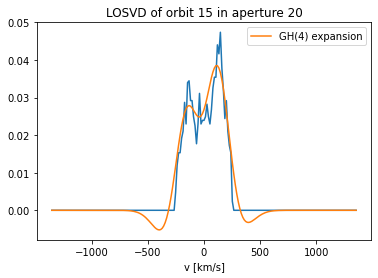

In [14]:
gh_losvd = kinematics.evaluate_losvd(velhist.x,
                                     np.array([v]),
                                     np.array([sigma]),
                                     gh_coefficients)
gh_losvd = np.squeeze(gh_losvd)

# normalise the two LOSVDs so that we can plot them on the same axis
losvd /= np.sum(losvd) 
gh_losvd /= np.sum(gh_losvd)

# plot
plt.plot(v_arr, losvd)
plt.plot(v_arr, gh_losvd, label='GH(4) expansion')
plt.gca().legend()
plt.gca().set_xlabel('v [km/s]')
title = f'LOSVD of orbit {orb_idx} in aperture {aperture_idx}'
_ = plt.gca().set_title(title)

The Gauss Hermite parameterisaion of the LOSVD does an OK job at reproducing the bimodality of the LOSVD, although the peaks are somewhat underpredicted. The cost of this, however, are significant, unphysical negative wings!

This isn't good! The LOSVD should not become negative. The fact that is does could bias our modelling. This is one of our key motivations for wanting to replace Gauss Hermites with different parametresiations of the LOSVD.

## Looking at the oribtal weights

Let's look at the best fitting orbital weights,

In [15]:
model.get_weights()
model.weight_solver.read_weights()
model.weight_solver.weights

NNLS solution read from existing output


<Table length=180>
orb_idx E_idx I2_idx I3_idx orb_type    weight    lcut
 int64  int64 int64  int64   int64     float64   int64
------- ----- ------ ------ -------- ----------- -----
      1     1      1      1        3 0.000602178    -1
      2     1     -1      1        3         0.0    -1
      3     1      1      2        3         0.0    -1
      4     1     -1      2        3         0.0    -1
      5     1      1      3        3         0.0    -1
      6     1     -1      3        3         0.0    -1
      7     1      2      1        3         0.0    -1
      8     1     -2      1        3         0.0    -1
      9     1      2      2        3         0.0    -1
     10     1     -2      2        3         0.0    -1
    ...   ...    ...    ...      ...         ...   ...
    171    -5      1      3        4  0.00745174    -1
    172    -5      2      1        4         0.0    -1
    173    -5      2      2        4         0.0    -1
    174    -5      2      3        4         0.0    -1
    175    -5      3      1        4  0.00574814    -1
    176    -5      3      2        4   0.0177199    -1
    177    -5      3      3        4   0.0489347    -1
    178    -5      4      1        4         0.0    -1
    179    -5      4      2        4         0.0    -1
    180    -5      4      3        4         0.0    -1

There is a row for every orbit, a weight for every orbit.

What does the LOSVD look like for this set of weights? Again, if we just stick to the same aperture we were looking at earlier, then 

For this set of weights (found buy the NNL optimization routine) let's look at the model LOSVD that we produce, again in the same aperture we were looking at above, and compare it to the observed LOSVD there

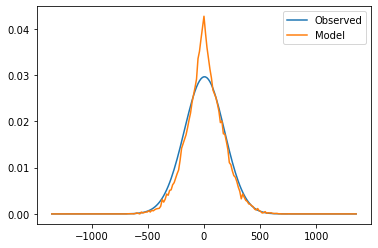

In [16]:
# extract the model LOSVD for the orbital weights above
w = model.weight_solver.weights['weight']
orbit_losvds = model.orblib.losvd_histograms.y

model_losvd = np.dot(orbit_losvds.T, w).T
model_losvd /= np.sum(model_losvd, 0)

# extract the observed LOSVD
v, sigma, h3, h4 = kinematics.data[aperture_idx]['v', 'sigma', 'h3', 'h4']
h0, h1, h2 = 1., 0., 0.
gh_coefficients = np.array([[[h0, h1, h2, h3, h4]]])

gh_losvd_obs = kinematics.evaluate_losvd(velhist.x,
                                     np.array([v]),
                                     np.array([sigma]),
                                     gh_coefficients)
gh_losvd_obs = np.squeeze(gh_losvd_obs)
gh_losvd_obs /= np.sum(gh_losvd_obs)
gh_losvd_obs = np.squeeze(gh_losvd_obs)

# plot them
plt.plot(v_arr, np.squeeze(gh_losvd_obs), label='Observed')
plt.plot(v_arr, model_losvd[:, aperture_idx], label='Model')
plt.gca().legend()

The width is good! But what about the sharp peak!? What's that!?

The 'model' LOSVD we plotted above is the weighted sum of the histogrammed orbit LOSVDS. But, the comparisaon against observations was done with Gauss Hermite expansions, not histograms. Let look at what the model distributions with Gauss Hermites would look like,

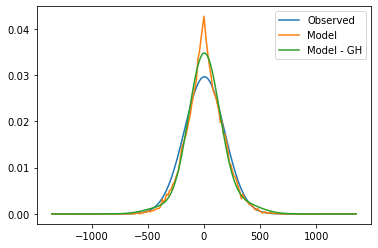

In [17]:
tmp = model.orblib.losvd_histograms.y[:,:,aperture_idx]
vel_hist = dyn.kinematics.Histogram(
    xedg=model.orblib.losvd_histograms.xedg,
    y=tmp,
    normalise=False)

gh_coefficients = kinematics.get_gh_expansion_coefficients(
    v_mu=kinematics.data['v'][aperture_idx],
    v_sig=kinematics.data['sigma'][aperture_idx],
    vel_hist=vel_hist,
    max_order=4)

gh_orb_losvd = kinematics.evaluate_losvd(
    velhist.x,
    kinematics.data['v'][[aperture_idx]],
    kinematics.data['sigma'][[aperture_idx]],
    gh_coefficients)
gh_orb_losvd = np.squeeze(gh_orb_losvd)
gh_orb_losvd = np.dot(gh_orb_losvd.T, w).T
gh_orb_losvd /= np.sum(gh_orb_losvd)

# plot them
plt.plot(v_arr, np.squeeze(gh_losvd_obs), label='Observed')
plt.plot(v_arr, model_losvd[:, aperture_idx], label='Model')
plt.plot(v_arr, gh_orb_losvd, label='Model - GH')
plt.gca().legend()

By construciton, the GH representation of the model is a better match to the observations. But the fact that the GH representation of the model is visibly different from the model constructed from histograms is again a sign that the GH expansion is not ideal.